In [139]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


/Users/lukas/Code/active_sciencing/venv/lib/python2.7/site-packages/IPython/core/magics/pylab.py:161: UserWarning: pylab import has clobbered these variables: ['entropy', 'ndim']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [140]:
def a_fb(sqrtshalf,gf):
    MZ = 90
    GFNom = 1.0

    sqrts = sqrtshalf*2.
    A_FB_EN = np.tanh((sqrts-MZ)/MZ*10)
    A_FB_GF = gf/GFNom
    return 2*A_FB_EN*A_FB_GF
    
def diffxsec(costheta,sqrtshalf,gf):
    norm = 2.*((1.+1./3.))
    return ((1+costheta**2)+a_fb(sqrtshalf,gf)*costheta)/norm

In [141]:
def rej_sample_costheta(nsamples,sqrtshalf,gf):
    samples = []
    x = np.linspace(-1,1,num = 1000)
    maxval = np.max(diffxsec(x,sqrtshalf,gf))
    while len(samples) < nsamples:
        xprop  = np.random.uniform(-1,1)
        ycut = np.random.random()
        yprop = diffxsec(xprop,sqrtshalf,gf)/maxval
        if yprop/maxval < ycut:
            continue
        samples.append(xprop)
    return np.array(samples)

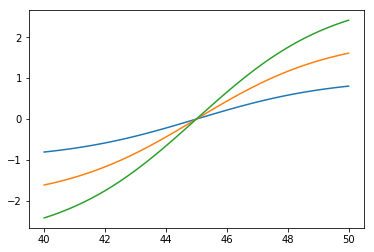

In [143]:
x = np.linspace(40,50,100)
plt.plot(x,a_fb(x,0.5))
plt.plot(x,a_fb(x,1.0))
plt.plot(x,a_fb(x,1.5))

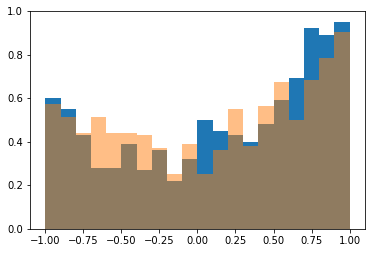

In [17]:
v,b,p = plt.hist(rej_sample_costheta(1000,46,1.5), bins = 20, normed=True)
v,b,p = plt.hist(rej_sample_costheta(1000,46,1.0), bins = b, normed=True, alpha = 0.5)

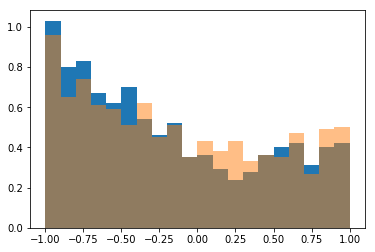

In [18]:
v,b,p = plt.hist(rej_sample_costheta(1000,44,1.5), bins = 20, normed=True)
v,b,p = plt.hist(rej_sample_costheta(1000,44,1.0), bins = b, normed=True, alpha = 0.5)

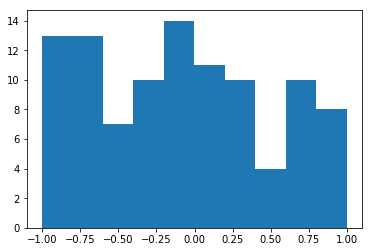

In [19]:
data = rej_sample_costheta(100,44,1.0)
_=plt.hist(data)

In [20]:
import emcee

<Container object of 3 artists>

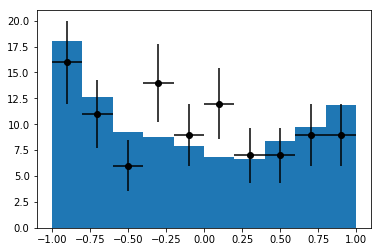

In [23]:
mc = rej_sample_costheta(1000,44,1.0)
data = rej_sample_costheta(100,44,1.0)
mccounts,bins,_ = plt.hist(mc,weights = [float(len(data))/float(len(mc))]*len(mc), bins = np.linspace(-1,1,11))
datacounts,bins = np.histogram(data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

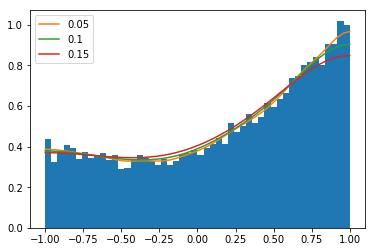

In [146]:
mc = rej_sample_costheta(10000,47,1.0)
mirrored = np.concatenate([(-2-mc),mc,(2-mc)])
from scipy.stats import entropy, gaussian_kde
plt.hist(mc,normed = True, bins = 50)
for bw in np.linspace(0.05,0.15,3):
    kernel = gaussian_kde(mirrored, bw_method=bw)
    xs = np.linspace(-1,1)
    plt.plot(xs, [3*kernel(x) for x in xs], label = bw)

plt.legend()

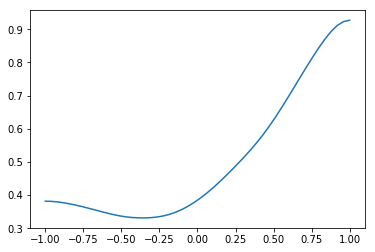

In [147]:
from scipy.stats import entropy, gaussian_kde
def approx_logpdf(mc,bw = 0.1):
    mirrored = np.concatenate([(-2-mc),mc,(2-mc)])
    kernel = gaussian_kde(mirrored, bw_method=bw)
    def func(x):
        return np.log(3)+kernel.logpdf(x)
    return func
    
pdf = approx_logpdf(mc,bw = 0.08)
x = np.linspace(-1,1)
y = pdf(x)
plt.plot(x,np.exp(y))

In [195]:
phi_true, theta_true= 47, 0.55
data = rej_sample_costheta(500,phi_true,theta_true)

<Container object of 3 artists>

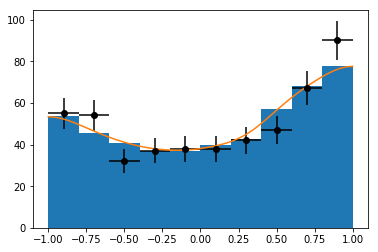

In [196]:
mc = rej_sample_costheta(10000,phi_true,theta_true)
mcweight = float(len(data))/float(len(mc))
mccounts,bins,_ =plt.hist(mc,weights = [mcweight]*len(mc), bins = np.linspace(-1,1,11))
datacounts,bins = np.histogram(data,bins = bins)
centers = bins[:-1] + (bins[1:]-bins[:-1])/2.

logmcpdf = approx_logpdf(mc,bw = 0.08)
x = np.linspace(-1,1)
plt.plot(x,len(data)*(bins[1]-bins[0])*np.exp(logmcpdf(x)))
plt.errorbar(centers,datacounts,fmt = 'o',xerr = (bins[1:]-bins[:-1])/2.,yerr = np.sqrt(datacounts), c = 'k')

In [197]:
def lnprior(theta):
    if 0.5 < theta < 1.5:
        return 0.0
    return -np.inf

def lnlike(theta, x, phi):
    mc = rej_sample_costheta(1000,phi,theta)
    logpdf = approx_logpdf(mc)
    return np.sum(logpdf(x))

def lnprob(theta, x, phi):
    lp = lnprior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

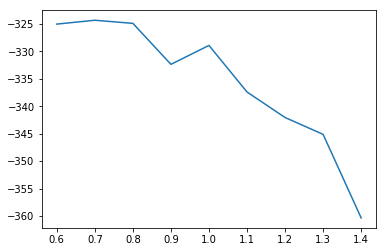

In [198]:
test_thetas = np.linspace(0.5,1.5,11)
nll = [lnprob(theta_test,data,phi_true) for theta_test in test_thetas]
plt.plot(test_thetas,nll)

In [199]:
import emcee
ndim, nwalkers = 1, 10
pos = [np.array([x]) for x in np.random.uniform(0.5,1.5,size=nwalkers)]
sampler = emcee.EnsembleSampler(nwalkers, ndim, lnprob, args=(data,phi_true))
_ = sampler.run_mcmc(pos, 50)

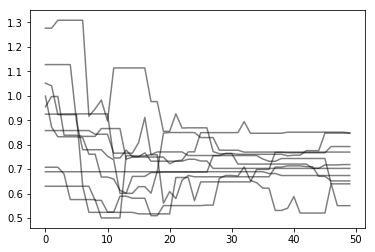

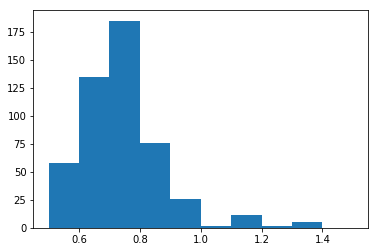

In [200]:
samples = sampler.chain
for x in samples:
    plt.plot(x, alpha = 0.5, c = 'k')
plt.show()
_=plt.hist(sampler.flatchain, bins = np.linspace(0.5,1.5,11))

In [216]:
def simulator(theta,phi,n_samples):
    return rej_sample_costheta(n_samples,phi,theta)


def collect_data(phi, n_samples = 500):
    THETA_NATURE = 1.0
    return simulator(THETA_NATURE,phi,n_samples)

In [220]:
def lnprior(theta, prior):
    p = prior.pdf(theta)
    if p <= 1e-8:
        return -np.inf
    else:
        return np.log(p)

def lnlike(theta, x, phi):
    mc = rej_sample_costheta(1000,phi,theta)
    logpdf = approx_logpdf(mc)
    return np.sum(logpdf(x))

def lnprob(theta, x, prior, phi):
    lp = lnprior(theta, prior)
    if not np.isfinite(lp):
        return -np.inf
    return lp + lnlike(theta, x, phi)

In [221]:
def calculate_posterior(prior, data, phi):
    """Compute samples from the posterior"""
    ndim, n_walkers = 1, 10
    # initialise walkers from the MAP + noise
    # XXX alternatively sample a point from the KDE without adding noise?
    # XXX not sure if the noise takes us into a region where the prior is zero?
    pos = [prior.map() + 1e-1*np.random.randn(ndim) for i in range(n_walkers)]
    
    sampler = emcee.EnsembleSampler(n_walkers, 1, lnprob, args=(data, prior, phi))
    pos, prob, state = sampler.run_mcmc(pos, 100)
    
    sampler.reset()
    pos, prob, state = sampler.run_mcmc(pos, 300)
    
    return Distribution(prior.name, prior.range, sampler.flatchain)